In [1]:
%matplotlib notebook
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
from scipy.stats import circstd

from kalman_experiments import SSPE
from kalman_experiments.models import MatsudaParams, SingleRhythmModel, collect, gen_ar_noise_coefficients, ArNoise
from kalman_experiments.kalman import PerturbedP1DMatsudaKF, apply_kf
from kalman_experiments.model_selection import fit_kf_parameters

SRATE = 500
DURATION = 1000
FREQ_GT = 6
SIGNAL_SIGMA_GT = np.sqrt(10)
# SIGNAL_SIGMA_GT = 10
NOISE_SIGMA_GT = 1
A_GT = 0.99
ALPHA = 1.5
NOISE_AR_ORDER = 1000

data = {}
phases = {}
gt = {}

data["sines_in_white"], gt["sines_in_white"], phases["sines_in_white"] = SSPE.gen_sine_w_white(DURATION, SRATE)
data["sines_in_pink"], gt["sines_in_pink"], phases["sines_in_pink"] = SSPE.gen_sine_w_pink(DURATION, SRATE)
data["filtered_pink"], gt["filtered_pink"], phases["filtered_pink"] = SSPE.gen_filt_pink_noise_w_added_pink_noise(DURATION, SRATE)

mp = MatsudaParams(A_GT, FREQ_GT, SRATE)
oscillation_model = SingleRhythmModel(mp, sigma=SIGNAL_SIGMA_GT)
gt_states = collect(oscillation_model, DURATION * SRATE)

noise_model = ArNoise(x0=np.random.rand(NOISE_AR_ORDER), alpha=ALPHA, order=NOISE_AR_ORDER, s=NOISE_SIGMA_GT)
noise_sim = collect(noise_model, DURATION * SRATE)
pink_noise_sspe = SSPE.make_pink_noise(ALPHA, DURATION * SRATE, 1/SRATE)
white_noise_sspe = NOISE_SIGMA_GT * np.random.randn(DURATION * SRATE)
data["state_space_model_white"] = np.real(gt_states).copy() + white_noise_sspe
data["state_space_model_pink"] = np.real(gt_states).copy() + noise_sim
# data["state_space_model"] = np.real(gt_states) + noise_sim
# data["state_space_model"] = np.real(gt_states) + 10 * pink_noise_sspe # NOISE_SIGMA_GT * SSPE.make_pink_noise(ALPHA, DURATION * SRATE, 1/SRATE)
phases["state_space_model_white"] = np.angle(gt_states.copy())
phases["state_space_model_pink"] = np.angle(gt_states.copy())

In [2]:
def theor_psd_mk_ar(f, s, A, f0, fs):
    phi = 2 * np.pi * f0 / fs
    psi = 2 * np.pi * f / fs
    return s**2 / np.abs(1 - 2 * A * np.cos(phi) * np.exp(-1j * psi) + A ** 2 * np.exp(-2j * psi)) ** 2


def theor_psd_mk_arma(f, s, A, f0, fs):
    phi = 2 * np.pi * f0 / fs
    psi = 2 * np.pi * f / fs
    
    a = (1 - 2 * A ** 2 * np.cos(phi) ** 2 + A ** 4 * np.cos(2 * phi) / (A * (A**2 - 1) * np.cos(phi)))
    b = 0.5 * (a - 2 * A * np.cos(phi) + np.sqrt((a - 2 * A * np.cos(phi)) ** 2 - 4))
    V = - s ** 2 * A * cc / b
         
    denom = np.abs(1 - 2 * A * np.cos(phi) * np.exp(-1j * psi) + A ** 2 * np.exp(-2j * psi))**2
    num = np.abs(1  + b * np.exp(-1j * psi)) ** 2
    return V * num / denom


def theor_psd_mk_mar(f, s, A, f0, fs):
    phi = 2 * np.pi * f0 / fs
    psi = 2 * np.pi * f / fs
    
    denom = np.abs(1 - 2 * A * np.cos(phi) * np.exp(-1j * psi) + A ** 2 * np.exp(-2j * psi))**2
    num = 1 + A ** 2 - 2 * A * np.cos(phi) * np.cos(psi)
    return s ** 2 * num / denom

In [3]:
def theor_psd(freqs, s, A, f0, fs):
    res = []
    c1 = np.cos(2 * np.pi * f0 / fs)
    for f in freqs:
        c2 = np.cos(2 * np.pi * f / fs)
        res.append(
            s ** 2 / np.sqrt(4 * A *(c1 - A * c2) * (A * c1 - c2) + (A ** 2 - 1) ** 2) / fs
#             * (1 + 60 * np.exp(-np.sqrt(np.abs(f - f0))))
        )
    return res

def theor_psd1(f, s, A, f0, fs):
    phi = 2 * np.pi * f0 / fs
    psi = 2 * np.pi * f / fs
    s_2_ = s ** 2 / fs
    return s_2_ / np.abs(1 - 2 * A * np.cos(phi) * np.exp(-1j * psi) + A ** 2 * np.exp(-2j * psi)) ** 2


def theor_psd2(freqs, s, A, f0, fs):
    res = []
    p1 = 2 * A * np.cos(2 * np.pi * f0 / fs)
    p2 =  - A ** 2
    p3 = A * np.sin(2 * np.pi * f0 / fs)
#     s_ = s * np.sqrt(1 + A ** 2)
    s_ = s
    for f in freqs:
        tmp = np.abs(1 - p1 * np.exp(-2 * np.pi * f * 1j / fs) - p2 * np.exp(-2 * np.pi * f * 2 * 1j / fs))**2
        tmp1 = np.abs(1  -p3 - p1 / 2 * np.exp(-2*np.pi*f*1j/fs)) ** 2
        res.append(s_ ** 2/ fs / tmp * tmp1)
    return res


def theor_psd3(freqs, s, A, f0, fs):
    res = []
    cc = np.cos(2 * np.pi * f0 / fs)
    ss = np.sin(2 * np.pi * f0 / fs)
    
    p1 = 2 * A * np.cos(2 * np.pi * f0 / fs)
    p2 =  - A ** 2
    p3 = A * np.sin(2 * np.pi * f0 / fs)
#     s_ = s * np.sqrt(1 + A ** 2)
    a = (1 - 2 * A ** 2 * cc ** 2 + A ** 4 * np.cos(4 * np.pi * f0 / fs)) / (A * (A**2 - 1) * cc)
    b = 0.5 * (a - 2 * A * cc + np.sqrt((a - 2 * A * cc) ** 2 - 4))
    V = - s ** 2 * A * cc / b / fs
    for f in freqs:
        tmp = np.abs(1 - p1 * np.exp(-2 * np.pi * f * 1j / fs) - p2 * np.exp(-2 * np.pi * f * 2 * 1j / fs))**2
        tmp1 = np.abs(1  + b * np.exp(-2*np.pi*f*1j/fs)) ** 2
        res.append(V * tmp1 / ( tmp))
    return res


def theor_psd4(freqs, s, A, f0, fs):
    res = []
    cc = np.cos(2 * np.pi * f0 / fs)
    ss = np.sin(2 * np.pi * f0 / fs)
    
    p1 = 2 * A * np.cos(2 * np.pi * f0 / fs)
    p2 =  - A ** 2
    p3 = A * np.sin(2 * np.pi * f0 / fs)
    a = (1 - 2 * A ** 2 * cc ** 2 + A ** 4 * np.cos(4 * np.pi * f0 / fs)) / (A * (A**2 - 1) * cc)
    V = s ** 2 / fs
    for f in freqs:
        tmp = np.abs(1 - p1 * np.exp(-2 * np.pi * f * 1j / fs) - p2 * np.exp(-2 * np.pi * f * 2 * 1j / fs))**2
        tmp1 = 1 - p2 - p1 * np.cos(2 * np.pi * f / fs)
        res.append(V * tmp1 / tmp)
    return res


def to_db(arr):
    return 10 * np.log10(arr)


def sim_matsuda_2nd_order(n_samp, A, f0, sr, s):
    x1, x2 = 0, 0
    phi1, phi2 = 2 * A * np.cos(2 * np.pi * f0 / sr),  -A ** 2
    res = [x2, x1]
#     s_ = s * np.sqrt(1 + A ** 2)
    s_ = s
    for t in range(n_samp):
        res.append(res[-1] * phi1 + res[-2] * phi2 + np.random.randn() * s_)
    return np.array(res)
        
    
def sim_matsuda_2nd_order1(n_samp, A, f0, sr, s):
    x1, x2 = 0, 0
    phi1, phi2 = 2 * A * np.cos(2 * np.pi * f0 / sr), - A ** 2
    res = [x2, x1]
#     s_ = s * np.sqrt(1 + A ** 2)
    s_ = s * np.sqrt(sr)
    noises = [np.random.randn() * s_, np.random.randn() * s_]
    for t in range(n_samp):
        n = noises[-1] - noises[-2] * A * np.cos(2 * np.pi * f0 / sr) - s_ * np.random.randn() * A * np.sin(2 * np.pi * f0 / sr)
        noises.append(np.random.randn() * s_)
        res.append(res[-1] * phi1 + res[-2] * phi2 + n)
    return np.array(res)

<IPython.core.display.Javascript object>


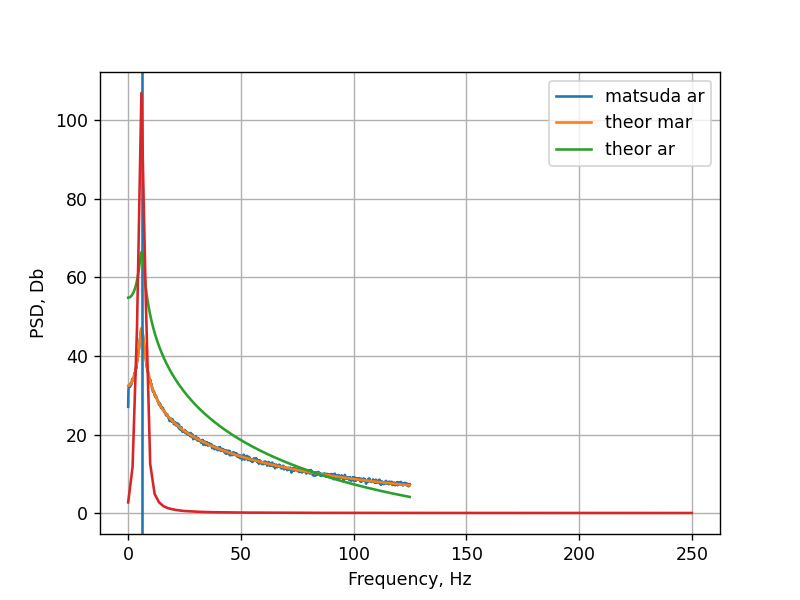

sines_in_white 1.016228378172416
sines_in_pink 0.027848919391209193
filtered_pink 0.023824278186549315
state_space_model_white 3.204823810076764
state_space_model_pink 2.5926164153697995
5.946559005809281
tp[-1] * 500=2543.5625011116003
matsuda[1999] * 500=2.275024804887051


249.875

In [4]:
FREQ_LIM = 1000
ss = sim_matsuda_2nd_order1(DURATION * SRATE, A_GT, FREQ_GT, SRATE, SIGNAL_SIGMA_GT)

plt.figure()
for k, d in data.items():
    freqs, psd = welch(d, fs=SRATE, nperseg=4000)
    print(k, psd[-3] * SRATE / 2)
#     plt.plot(freqs[:FREQ_LIM], to_db(psd[:FREQ_LIM]), label=k)
ff, matsuda = welch(np.real(gt_states), fs=SRATE, nperseg=4000, detrend=False, return_onesided=False, scaling="density")
tp = [theor_psd_mk_mar(f, SIGNAL_SIGMA_GT, A_GT, FREQ_GT, SRATE) for f in ff[:FREQ_LIM]]
tp1 = [theor_psd_mk_ar(f, SIGNAL_SIGMA_GT, A_GT, FREQ_GT, SRATE) for f in ff[:FREQ_LIM]]
_, sss = welch(ss, fs=SRATE,nperseg=4000, return_onesided=False)
plt.plot(ff[:FREQ_LIM], to_db(sss[:FREQ_LIM]), label="matsuda ar")
plt.plot(ff[:FREQ_LIM], to_db(np.array(tp)), label="theor mar")
plt.axvline(x=6)
plt.plot(ff[:FREQ_LIM], to_db(np.array(tp1)), label="theor ar")
# plt.plot(ff[:FREQ_LIM], to_db(matsuda[:FREQ_LIM]), label="matsuda")
# plt.loglog(ff[:FREQ_LIM], (pp[:FREQ_LIM]), label="gt states")
plt.grid()
plt.legend()
plt.xlabel("Frequency, Hz")
plt.ylabel("PSD, Db")
plt.show()

print(np.arccos(np.cos(2 * np.pi * 6 / SRATE) * (A_GT ** 2 + 1) / A_GT / 2) * SRATE / 2 / np.pi)
print(f"{tp[-1] * 500=}")
print(f"{matsuda[1999] * 500=}")

ff[1999]

<IPython.core.display.Javascript object>


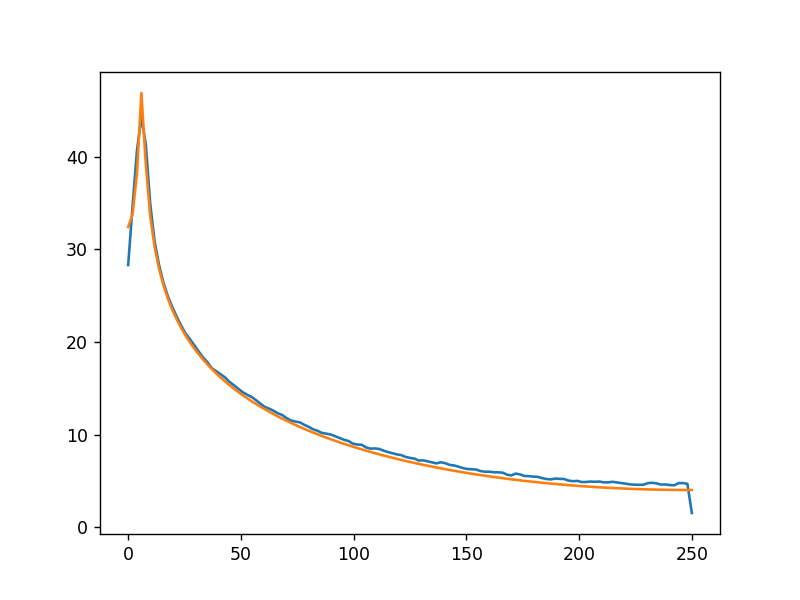

TypeError: gen_ar_noise_coefficients() missing 1 required positional argument: 'alpha'

In [13]:
dd = data["state_space_model_pink"]
ff, psd = welch(dd, fs=SRATE)
tp = [theor_psd_mk_mar(f, SIGNAL_SIGMA_GT, A_GT, FREQ_GT, SRATE) for f in ff[:FREQ_LIM]]
fig = plt.figure()
plt.plot(ff, to_db(psd/2*SRATE))
plt.plot(ff, to_db(tp))
plt.show()
f1 = 6
f2 = 12
ar_coef = gen_ar_noise_coefficients(order=30)
def psd_ar(f, ar_coef, s, fs):
    denom = 1 - sum(a * np.exp(-2j * np.pi * f / fs * m) for m, a in enumerate(ar_coef, 1))
    return s ** 2 / np.abs(denom) ** 2

from 
A = np.array([[theor_psd_mk_mar(f1)], [psd_]])

In [41]:
# Setup filters

A_KF = 0.99
FREQ_KF = 6
SIGNAL_SIGMA_KF = SIGNAL_SIGMA_GT
NOISE_SIGMA_KF = NOISE_SIGMA_GT

# kf = Difference1DMatsudaKF(A=A_KF, f=FREQ_KF, sr=SRATE, q_s=SIGNAL_SIGMA_KF, psi=PSI, r_s=NOISE_SIGMA_KF)
# kf = PerturbedP1DMatsudaKF(
#     A=A_KF, f=FREQ_KF, sr=SRATE, q_s=SIGNAL_SIGMA_KF, psi=noise_model.a, r_s=NOISE_SIGMA_KF, lambda_=0
# )
a = gen_ar_noise_coefficients(alpha=ALPHA, order=30)
# b = gen_ar_noise_coefficients(alpha=0, order=30)
mp = MatsudaParams(A_KF, FREQ_KF, SRATE)
kf_pink = PerturbedP1DMatsudaKF(mp, q_s=SIGNAL_SIGMA_KF, psi=a, r_s=NOISE_SIGMA_KF * 5, lambda_=0)
kf_white = PerturbedP1DMatsudaKF(mp, q_s=SIGNAL_SIGMA_KF, psi=np.array([0]), r_s=NOISE_SIGMA_KF * 5, lambda_=0)

qs, rs = {}, {}
qs["sines_in_white"] = {"white": 0.3, "pink": 0.3}
qs["sines_in_pink"] = {"white": 0.3, "pink": 0.2}
qs["filtered_pink"] = {"white": 0.4, "pink": 0.3}
qs["state_space_model_white"] = {"white": NOISE_SIGMA_GT, "pink": SIGNAL_SIGMA_GT}
qs["state_space_model_pink"] = {"white": SIGNAL_SIGMA_GT, "pink": SIGNAL_SIGMA_GT}

rs["sines_in_white"] = {"white": 1, "pink": 1}
rs["sines_in_pink"] = {"white": 0.1, "pink": 0.2}
rs["filtered_pink"] = {"white": 0.1, "pink": 0.2}
rs["state_space_model_white"] = {"white": NOISE_SIGMA_GT, "pink": NOISE_SIGMA_GT}
rs["state_space_model_pink"] = {"white": NOISE_SIGMA_GT, "pink": NOISE_SIGMA_GT}

In [58]:
print(" " * 18, "Pink KF", "White KF")
factors = []
pink_kf_cstd = []
white_kf_cstd = []
for k in data:
#     if k != "state_space_model_pink":
#         continue
    kf_pink.q_s = qs[k]["pink"]
    kf_pink.r_s = rs[k]["pink"]
    kf_pink_fit = fit_kf_parameters(data[k][:5000], kf_pink)
    print("kf_pink_params: ", kf_pink_fit.M, kf_pink_fit.q_s, kf_pink_fit.r_s)
    kf_white.q_s = qs[k]["white"]
    kf_white.r_s = rs[k]["white"]
    kf_white_fit = fit_kf_parameters(data[k][:5000], kf_white)
    print("kf_white_params: ", kf_white_fit.M, kf_white_fit.q_s, kf_white_fit.r_s)
    filtered_pink = apply_kf(kf_pink_fit, data[k], delay=0)
    filtered_white = apply_kf(kf_white_fit, data[k], delay=0)
    cstd_pink = circstd(np.angle(filtered_pink) - phases[k])
    cstd_white = circstd(np.angle(filtered_white) - phases[k])
#     print(f"{k:<18}", round(cstd_pink * 180 / np.pi, 2), round(cstd_white * 180 / np.pi,2))
    white_kf_cstd.append(cstd_white * 180 / np.pi)
    pink_kf_cstd.append(cstd_pink * 180 / np.pi)
    factors.append(k)

                   Pink KF White KF


Fitting KF parameters:  10%|██████████████▊                                                                                                                                         | 78/800 [01:12<11:12,  1.07it/s]


kf_pink_params:  MatsudaParams(A=0.9986504079990594, freq=5.97973558885662, sr=500) 0.36180795963380796 1.25043819710817


Fitting KF parameters:   6%|████████▋                                                                                                                                               | 46/800 [00:11<03:05,  4.07it/s]


kf_white_params:  MatsudaParams(A=0.9990919738707538, freq=5.998033355651524, sr=500) 0.30490820613387865 0.9604539202276997


Fitting KF parameters:   3%|████▊                                                                                                                                                   | 25/800 [00:19<10:08,  1.27it/s]


kf_pink_params:  MatsudaParams(A=0.9994098712315226, freq=5.9942755770960785, sr=500) 0.24702306024606627 0.2422388744948394


Fitting KF parameters:   2%|███▊                                                                                                                                                    | 20/800 [00:05<03:15,  3.99it/s]


kf_white_params:  MatsudaParams(A=0.998768242142965, freq=5.579863473552304, sr=500) 0.3683659555381748 0.1398883049380131


Fitting KF parameters:   2%|███▊                                                                                                                                                    | 20/800 [00:15<09:50,  1.32it/s]


kf_pink_params:  MatsudaParams(A=0.999317691422935, freq=5.542502779778901, sr=500) 0.33772081082885685 0.19874476469082078


Fitting KF parameters:   2%|███▌                                                                                                                                                    | 19/800 [00:04<03:15,  4.00it/s]


kf_white_params:  MatsudaParams(A=0.9989283228186434, freq=5.425351092783131, sr=500) 0.37134869534658865 0.1440273218477487


Fitting KF parameters:   2%|██▎                                                                                                                                                     | 12/800 [00:09<10:13,  1.28it/s]


kf_pink_params:  MatsudaParams(A=0.9915816719724901, freq=6.208840361779293, sr=500) 2.551482826867545 2.235993494766622


Fitting KF parameters:   1%|█▋                                                                                                                                                       | 9/800 [00:02<03:22,  3.91it/s]


kf_white_params:  MatsudaParams(A=0.9907742300267669, freq=6.138435318821819, sr=500) 2.749073645539353 1.6060047994474085


Fitting KF parameters:   2%|██▎                                                                                                                                                     | 12/800 [00:09<10:16,  1.28it/s]


kf_pink_params:  MatsudaParams(A=0.991944966527031, freq=6.203090179210862, sr=500) 2.5092171996874986 2.1210170423094525


Fitting KF parameters:   1%|█▌                                                                                                                                                       | 8/800 [00:02<03:27,  3.81it/s]


kf_white_params:  MatsudaParams(A=0.9909874522780575, freq=5.15001035998673, sr=500) 2.9317399931811767 1.4890417216011635


<IPython.core.display.Javascript object>


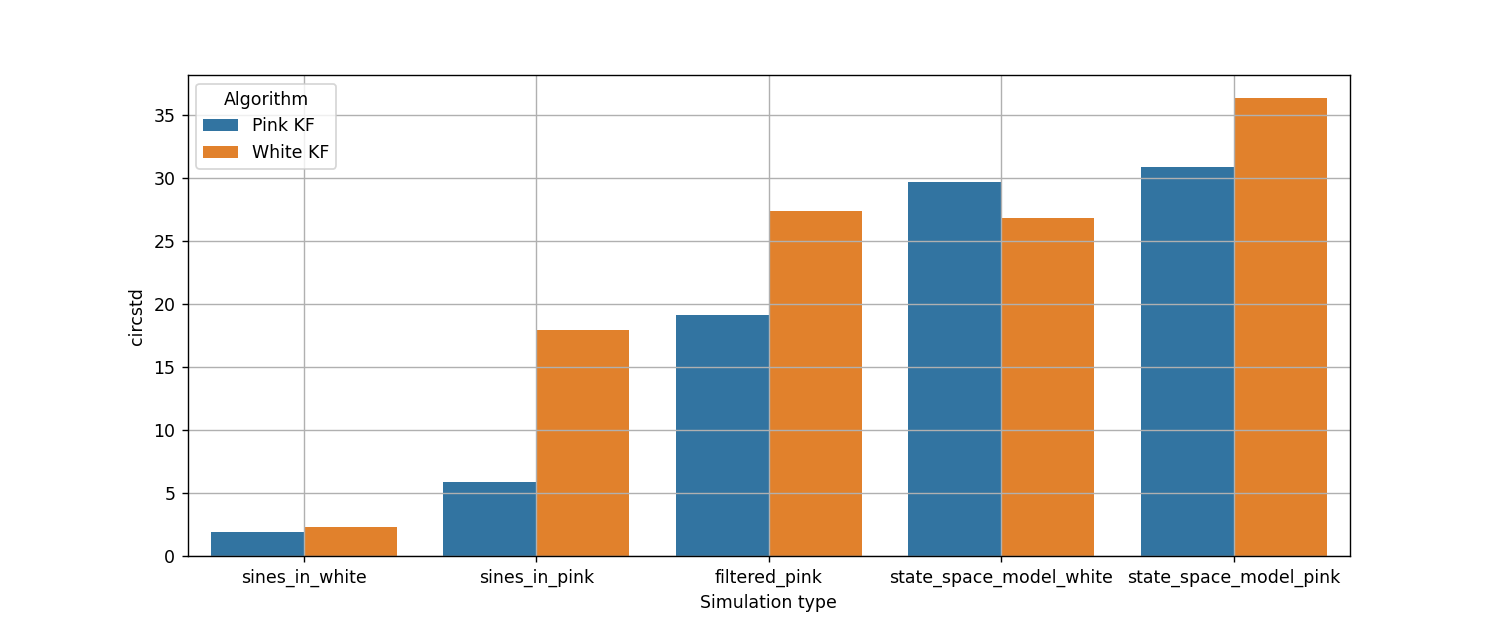

In [59]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame(
    {
        "Factor": factors,
        "Pink KF": pink_kf_cstd,
        "White KF": white_kf_cstd,
    }
)
fig = plt.figure(figsize=(12, 5))
tidy = df.melt(id_vars='Factor').rename(columns=str.title)
tt = tidy.rename(columns={"Value": "circstd", "Factor": "Simulation type", "Variable": "Algorithm"})
sns.barplot(data=tt, x="Simulation type", hue="Algorithm", y="circstd")
plt.grid()
plt.show()


In [60]:
df.T

,0,1,2,3,4
Factor,sines_in_white,sines_in_pink,filtered_pink,state_space_model_white,state_space_model_pink
Pink KF,1.901037,5.868407,19.175235,29.725005,30.897673
White KF,2.329878,17.959212,27.429268,26.880149,36.382157


In [116]:
f1, d1 = welch(noise_sim, fs=SRATE, nperseg=2000)
f2, d2 = welch(10 * pink_noise_sspe, fs=SRATE, nperseg=2000)
f3, d3 = welch(np.real(gt_states), fs=SRATE, nperseg=2000)
f4, d4 = welch(white_noise_sspe, fs=SRATE, nperseg=2000)

<IPython.core.display.Javascript object>


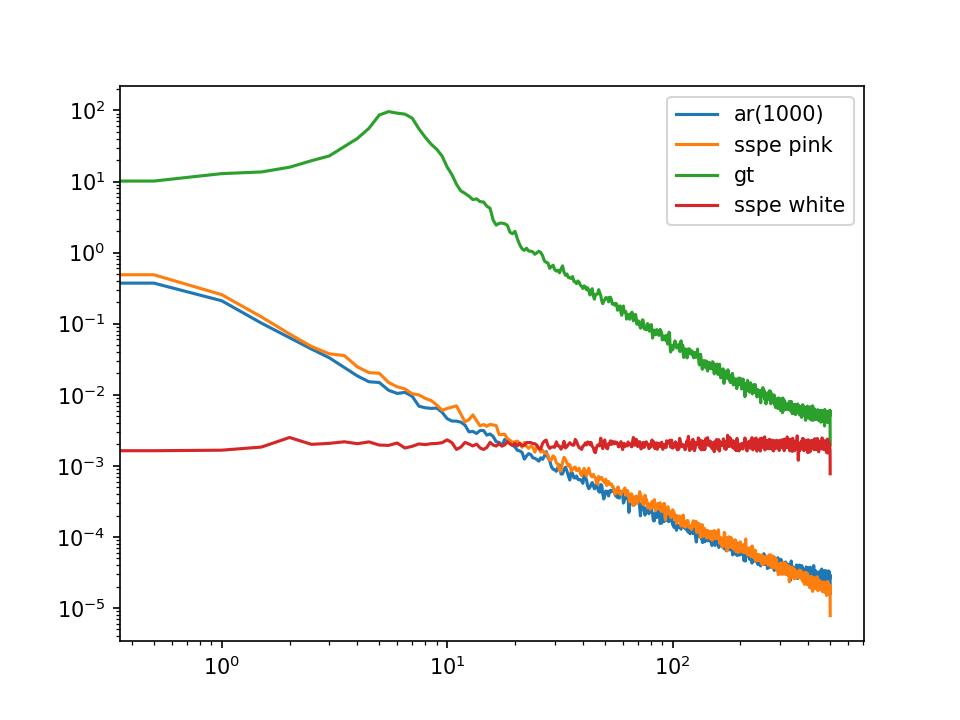

In [117]:
plt.figure()
plt.loglog(f1, d1, label="ar(1000)")
plt.loglog(f1, d2, label="sspe pink")
plt.loglog(f1, d3, label="gt")
plt.loglog(f1, d4, label="sspe white")
plt.legend()
plt.show()

In [ ]:
Dmitrii Altukhov, [31.10.2022 18:12]
sines_in_white     1.44 2.0

sines_in_pink      4.5 13.68

filtered_pink      15.26 22.43

state_space  67.15 35.34

Dmitrii Altukhov, [31.10.2022 18:13]
state_space_model  35.77 35.29

Dmitrii Altukhov, [31.10.2022 18:13]
state_space_model_pink 56.07 95.9